<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#(Run-model-until-August-1)" data-toc-modified-id="(Run-model-until-August-1)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>(Run model until August 1)</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li></ul></li><li><span><a href="#Scenarios-with-compliance" data-toc-modified-id="Scenarios-with-compliance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenarios with compliance</a></span><ul class="toc-item"><li><span><a href="#S1-(worst-case):-continuation-of-september-contact-behaviour" data-toc-modified-id="S1-(worst-case):-continuation-of-september-contact-behaviour-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>S1 (worst-case): continuation of september contact behaviour</a></span></li><li><span><a href="#S2:-Contacts-reduced-only-half-as-much-as-in-previous-lockdown" data-toc-modified-id="S2:-Contacts-reduced-only-half-as-much-as-in-previous-lockdown-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>S2: Contacts reduced only half as much as in previous lockdown</a></span></li><li><span><a href="#S3:-Contacts-reduced-as-much-as-in-previous-lockdown" data-toc-modified-id="S3:-Contacts-reduced-as-much-as-in-previous-lockdown-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>S3: Contacts reduced as much as in previous lockdown</a></span></li></ul></li><li><span><a href="#Summary-delayed-compliance" data-toc-modified-id="Summary-delayed-compliance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary delayed compliance</a></span></li><li><span><a href="#Scenarios-without-compliance" data-toc-modified-id="Scenarios-without-compliance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scenarios without compliance</a></span><ul class="toc-item"><li><span><a href="#S2-without-compliance" data-toc-modified-id="S2-without-compliance-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>S2 without compliance</a></span></li><li><span><a href="#S3-without-compliance" data-toc-modified-id="S3-without-compliance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>S3 without compliance</a></span></li></ul></li><li><span><a href="#Summary-immediate-compliance" data-toc-modified-id="Summary-immediate-compliance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary immediate compliance</a></span></li><li><span><a href="#Make-a-dataframe-to-output" data-toc-modified-id="Make-a-dataframe-to-output-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make a dataframe to output</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD, ramp_fun
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data, policy and model initialization

## Load contact data

In [3]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
#province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[50000].iloc[:9]))

## Load publically available data from Sciensano

In [4]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=True)
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Hainaut_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Hainaut']
# TOTAL_IN = H_tot !

## (Run model until August 1)

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
# out_aug = model.sim(time='2020-08-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
#                    N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
# states = out_aug.isel(time=-1).mean(dim="draws")
# initial_states_aug = {key:states[key].values for key in initial_states.keys()}

In [ ]:
## To work with Tijs' lockdown function, use int here:
t = (pd.to_datetime('2020-08-01') - pd.to_datetime('2020-03-15'))/pd.to_timedelta('1D')
out_aug = model.sim(time=139,start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug = {key:states[key].values for key in initial_states.keys()}

## Load posterior parameter distributions of calibrated parameters

In [5]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-04.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

with open('../data/interim/model_parameters/provinces/Hainaut_wave2_from_aug1_no_policies_2020-11-04.json', 'r') as fp:
    samples_dict_wave2 = json.load(fp)

In [6]:
samples_dict_wave2.update({'l':samples_dict_wave1['l'],
                           'tau':samples_dict_wave1['tau']})
                          # 'prevention':samples_dict_wave1['prevention']

<IPython.core.display.Javascript object>


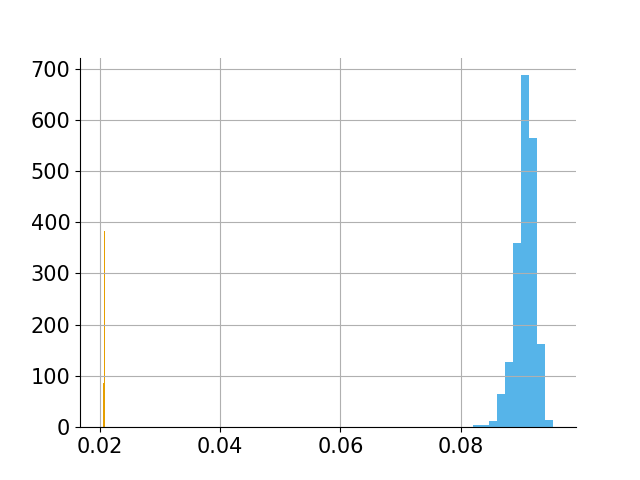

In [7]:
fig,ax = plt.subplots()
pd.Series(samples_dict_wave2['beta']).hist()
pd.Series(samples_dict_wave1['beta']).hist()

# Scenarios with compliance

In [33]:
start_date = '2020-08-01'
n_draws = 100
UL = 0.975
LL = 0.025
end_date = '2021-01-01'
dates_full = pd.date_range(start_date, end_date)

In [17]:
initial_states_aug = np.load('../data/interim/initial_states_provinces/Hainaut_wave1_Aug1.npy', allow_pickle=True).item()

## S1 (worst-case): continuation of september contact behaviour

In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model

model = models.COVID19_SEIRD(initial_states, params)
# Run simulation
out_S1 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave2,to_sample=['beta'])
# Save results
# New hospitalisations
S1_incidences_mean = out_S1["H_in"].sum(dim="Nc").mean(dim="draws").values
S1_incidences_median = out_S1["H_in"].sum(dim="Nc").median(dim="draws").values
S1_incidences_LL = out_S1["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_incidences_UL = out_S1["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S1_load_mean = out_S1["H_tot"].sum(dim="Nc").mean(dim="draws").values
S1_load_median = out_S1["H_tot"].sum(dim="Nc").median(dim="draws").values
S1_load_LL = out_S1["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_load_UL = out_S1["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

In [ ]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S1["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S1["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()


In [ ]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S1["H_in"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S1["H_in"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S1["H_in"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["NEW_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('daily hospitalisations')
fig.tight_layout()


## S2: Contacts reduced only half as much as in previous lockdown

In [18]:
def contact_reduction_half(t, param, policy0, policy_half, policy_half_school_vacation, l, tau):
    """
    policy0 : before any measures are take, so full contacts
    policy_half : half contact reduction as compared to first lockdown (schools open)
    policy_half_school_vacation : policy_half, but schools closed
    tau : number of days before measures start having an effect
    l : number of additional days after the time delay until full compliance is reached
    """
    t1 = pd.to_datetime('2020-10-19') # start measures
    t2 = pd.to_datetime('2020-11-02') # start autumn vacation
    t3 = pd.to_datetime('2020-11-11') # end autumn vacation
    t4 = pd.to_datetime('2020-12-21') # start Christmas vacation
    tau_days = pd.to_timedelta(tau, unit='D')
    l_days = pd.to_timedelta(l, unit='D')
    
    if t <= t1 + tau_days:
        return policy0
    elif (t1 + tau_days) < t <= (t1 + tau_days + l_days):
        return ramp_fun(policy0, policy_half, t, tau_days, l, t1)
    elif (t1 + tau_days + l_days) < t < t2:
        return policy_half
    elif t2 <= t <= t3:
        return policy_half_school_vacation
    elif t3 < t < t4 :
        return policy_half
    elif t4 <= t:
        return policy_half_school_vacation

In [19]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({      'policy0': Nc_total,
                 'policy_half': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 1*Nc_schools + (1-0.40)*Nc_leisure,
 'policy_half_school_vacation': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 0*Nc_schools + (1-0.40)*Nc_leisure,
                          'l': 1,
                        'tau': 5})


# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_half})
# Run simulation
out_S2 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave2,to_sample=['beta','l','tau'])
# Save results
# New hospitalisations
S2_incidences_mean = out_S2["H_in"].sum(dim="Nc").mean(dim="draws").values
S2_incidences_median = out_S2["H_in"].sum(dim="Nc").median(dim="draws").values
S2_incidences_LL = out_S2["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_incidences_UL = out_S2["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S2_load_mean = out_S2["H_tot"].sum(dim="Nc").mean(dim="draws").values
S2_load_median = out_S2["H_tot"].sum(dim="Nc").median(dim="draws").values
S2_load_LL = out_S2["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_load_UL = out_S2["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


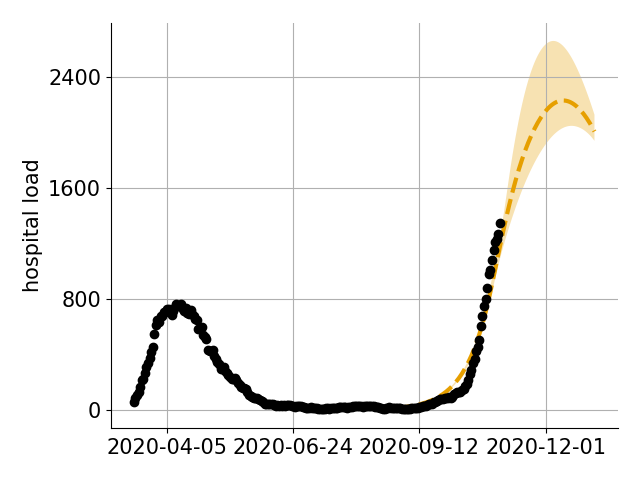

In [35]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S2["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), out_S2["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(out_S2['time'],out_S2["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Hainaut_hosp_data.DATE,Hainaut_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

## S3: Contacts reduced as much as in previous lockdown

In [21]:
def contact_reduction_full(t, param, policy0, policy_full, policy_full_school_vacation, l, tau):
    """
    policy0 : before any measures are take, so full contacts
    policy_full : same contact reduction as first lockdown (schools open)
    policy_full_school_vacation : policy_full, but schools closed
    tau : number of days before measures start having an effect
    l : number of additional days after the time delay until full compliance is reached 
    """
    t1 = pd.to_datetime('2020-10-19') # start measures
    t2 = pd.to_datetime('2020-11-02') # start autumn vacation
    t3 = pd.to_datetime('2020-11-11') # end autumn vacation
    t4 = pd.to_datetime('2020-12-21') # start Christmas vacation
    tau_days = pd.to_timedelta(tau, unit='D')
    l_days = pd.to_timedelta(l, unit='D')
    
    if t <= t1 + tau_days:
        return policy0
    elif (t1 + tau_days) < t <= (t1 + tau_days + l_days):
        return ramp_fun(policy0, policy_full, t, tau_days, l, t1)
    elif (t1 + tau_days + l_days) < t < t2:
        return policy_full
    elif t2 <= t <= t3:
        return policy_full_school_vacation
    elif t3 < t < t4 :
        return policy_full
    elif t4 <= t:
        return policy_full_school_vacation

In [22]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({     'policy0': Nc_total,
                'policy_full': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 1*Nc_schools + (1-0.80)*Nc_leisure,
'policy_full_school_vacation': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 0*Nc_schools + (1-0.80)*Nc_leisure,
                          'l': 1,
                        'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_full})
# Run simulation
out_S3 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave2,to_sample=['beta','l','tau'])
# Save results
# New hospitalisations
S3_incidences_mean = out_S3["H_in"].sum(dim="Nc").mean(dim="draws").values
S3_incidences_median = out_S3["H_in"].sum(dim="Nc").median(dim="draws").values
S3_incidences_LL = out_S3["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_incidences_UL = out_S3["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S3_load_mean = out_S3["H_tot"].sum(dim="Nc").mean(dim="draws").values
S3_load_median = out_S3["H_tot"].sum(dim="Nc").median(dim="draws").values
S3_load_LL = out_S3["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_load_UL = out_S3["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


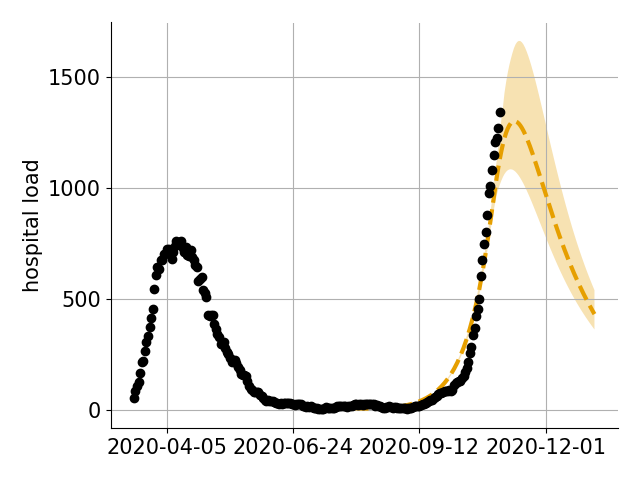

In [24]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S3["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), out_S3["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S3["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Hainaut_hosp_data.DATE,Hainaut_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

# Summary delayed compliance

In [25]:
Hainaut_pop = np.sum(initN)

<IPython.core.display.Javascript object>


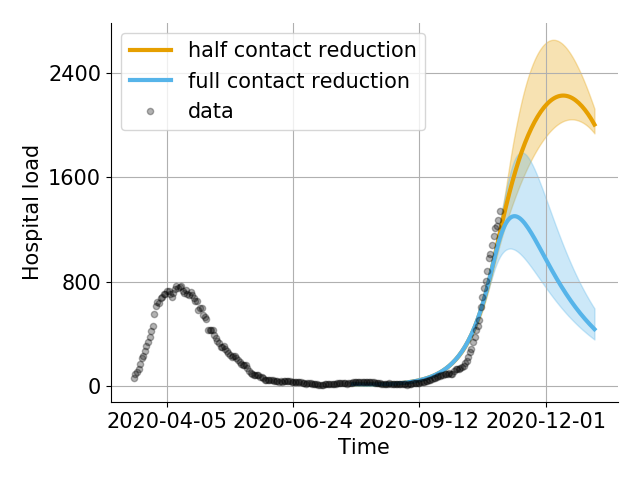

In [36]:
fig,ax =plt.subplots()
# ax.fill_between(dates_full, out_S1["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),
#                 out_S1["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"),alpha=0.30, color='C0')
# ax.plot(dates_full,out_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C0', label='S1')

ax.fill_between(dates_full, out_S2["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"),
                out_S2["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30, color='C0')
ax.plot(dates_full,out_S2["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C0', label='half contact reduction')

ax.fill_between(dates_full, out_S3["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), 
                out_S3["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30, color='C1')
ax.plot(dates_full,out_S3["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C1', label='full contact reduction')

ax.plot(Hainaut_hosp_data.DATE,Hainaut_hosp_data["TOTAL_IN"],'.',color='black', markersize=9, alpha=0.3, label='data')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('Hospital load')
ax.set_xlabel('Time')
plt.legend()
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
fig.tight_layout()
plt.savefig('../results/predictions_provinces/Hainaut_combined_results_delayed_compliance.jpg', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


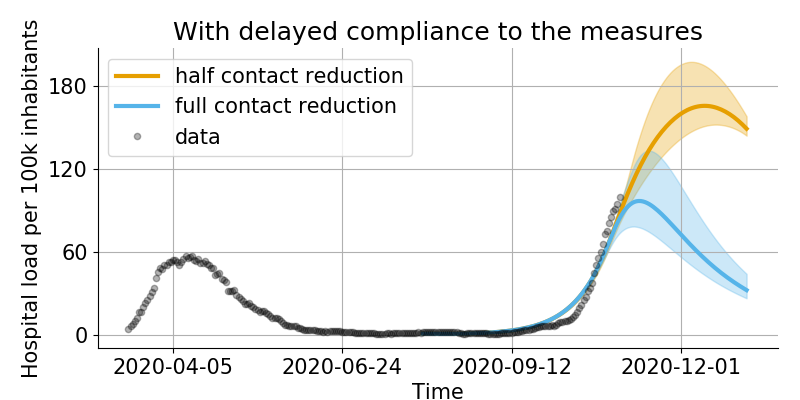

In [37]:
fig,ax =plt.subplots(figsize=(8,4))
S2_load_mean_rel = out_S2["H_tot"].mean(dim="draws").sum(dim="Nc")/Hainaut_pop*100000
S3_load_mean_rel = out_S3["H_tot"].mean(dim="draws").sum(dim="Nc")/Hainaut_pop*100000

ax.fill_between(dates_full, out_S2["H_tot"].quantile(LL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,
                out_S2["H_tot"].quantile(UL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,alpha=0.30, color='C0')
ax.plot(dates_full,S2_load_mean_rel,'-', color='C0', label='half contact reduction')

ax.fill_between(dates_full, out_S3["H_tot"].quantile(LL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000, 
                out_S3["H_tot"].quantile(UL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,alpha=0.30, color='C1')
ax.plot(dates_full,S3_load_mean_rel,'-', color='C1', label='full contact reduction')

ax.plot(Hainaut_hosp_data.DATE,Hainaut_hosp_data["TOTAL_IN"]/Hainaut_pop*100000,'.',color='black', markersize=9, alpha=0.3, label='data')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('Hospital load per 100k inhabitants')
fig.tight_layout()
ax.set_xlabel('Time')
plt.legend()
plt.title('With delayed compliance to the measures')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.savefig('../results/predictions_provinces/Hainaut_combined_results_delayed_compliance_100k.jpg', dpi=400, bbox_inches='tight')

In [38]:
pd.DataFrame({'half_contact_reduction':S2_load_mean_rel, 
              'full_contact_reduction':S3_load_mean_rel}).to_csv(
    '../results/predictions_provinces/Hainaut_combined_results_delayed_compliance_100k.csv')

# Scenarios without compliance

## S2 without compliance

In [39]:
def contact_reduction_half_no_compliance(t, param, policy0, policy_half, policy_half_school_vacation):
    """
    policy0 : before any measures are take, so full contacts
    policy_half : half contact reduction as compared to first lockdown (schools open)
    policy_half_school_vacation : policy_half, but schools closed
    """
    t1 = pd.to_datetime('2020-10-19') # start measures
    t2 = pd.to_datetime('2020-11-02') # start autumn vacation
    t3 = pd.to_datetime('2020-11-11') # end autumn vacation
    t4 = pd.to_datetime('2020-12-21') # start Christmas vacation
    
    if t <= t1:
        return policy0
    elif t1 < t < t2:
        return policy_half
    elif t2 <= t <= t3:
        return policy_half_school_vacation
    elif t3 < t < t4 :
        return policy_half
    elif t4 <= t:
        return policy_half_school_vacation

In [40]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({      'policy0': Nc_total,
                 'policy_half': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 1*Nc_schools + (1-0.40)*Nc_leisure,
 'policy_half_school_vacation': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 0*Nc_schools + (1-0.40)*Nc_leisure,
})


# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_half_no_compliance})
# Run simulation
out_S2_no_comp = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave2,to_sample=['beta'])
# Save results


## S3 without compliance

In [41]:
def contact_reduction_full_no_compliance(t, param, policy0, policy_full, policy_full_school_vacation):
    """
    policy0 : before any measures are take, so full contacts
    policy_full : full contact reduction as compared to first lockdown (schools open)
    policy_full_school_vacation : policy_full, but schools closed
    """
    t1 = pd.to_datetime('2020-10-19') # start measures
    t2 = pd.to_datetime('2020-11-02') # start autumn vacation
    t3 = pd.to_datetime('2020-11-11') # end autumn vacation
    t4 = pd.to_datetime('2020-12-21') # start Christmas vacation
    
    if t <= t1:
        return policy0
    elif t1 < t < t2:
        return policy_full
    elif t2 <= t <= t3:
        return policy_full_school_vacation
    elif t3 < t < t4 :
        return policy_full
    elif t4 <= t:
        return policy_full_school_vacation

In [42]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({     'policy0': Nc_total,
                'policy_full': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 1*Nc_schools + (1-0.80)*Nc_leisure,
'policy_full_school_vacation': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 0*Nc_schools + (1-0.80)*Nc_leisure,
})


# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_full_no_compliance})
# Run simulation
out_S3_no_comp = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave2,to_sample=['beta'])
# Save results


# Summary immediate compliance

<IPython.core.display.Javascript object>


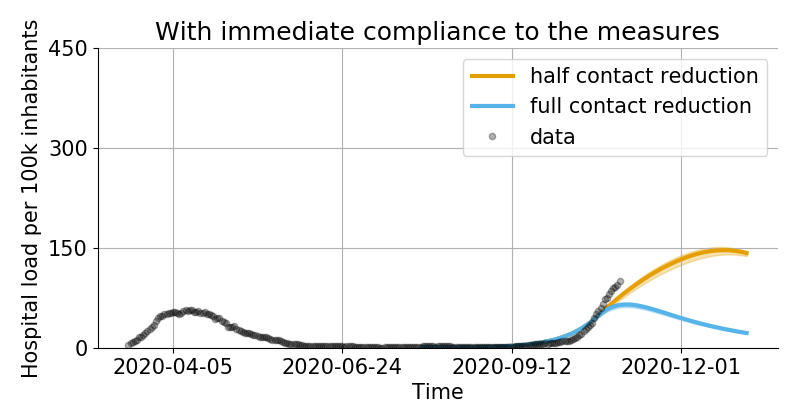

In [44]:
fig,ax =plt.subplots(figsize=(8,4))
S2_no_comp_load_mean_rel = out_S2_no_comp["H_tot"].mean(dim="draws").sum(dim="Nc")/Hainaut_pop*100000
S3_no_comp_load_mean_rel = out_S3_no_comp["H_tot"].mean(dim="draws").sum(dim="Nc")/Hainaut_pop*100000

ax.fill_between(dates_full, out_S2_no_comp["H_tot"].quantile(LL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,
                out_S2_no_comp["H_tot"].quantile(UL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,alpha=0.30, color='C0')
ax.plot(dates_full,S2_no_comp_load_mean_rel,'-', color='C0', label='half contact reduction')

ax.fill_between(dates_full, out_S3_no_comp["H_tot"].quantile(LL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000, 
                out_S3_no_comp["H_tot"].quantile(UL,dim="draws").sum(dim="Nc")/Hainaut_pop*100000,alpha=0.30, color='C1')
ax.plot(dates_full,S3_no_comp_load_mean_rel,'-', color='C1', label='full contact reduction')

ax.plot(Hainaut_hosp_data.DATE,Hainaut_hosp_data["TOTAL_IN"]/Hainaut_pop*100000,'.',color='black', markersize=9, alpha=0.3, label='data')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('Hospital load per 100k inhabitants')
fig.tight_layout()
ax.set_xlabel('Time')
ax.set_ylim(0,450)
plt.legend()
plt.title('With immediate compliance to the measures')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.savefig('../results/predictions_provinces/Hainaut_combined_results_immediate_compliance_100k.jpg', dpi=400, bbox_inches='tight')

In [46]:
pd.DataFrame({'half_contact_reduction':S2_load_mean_rel, 
              'full_contact_reduction':S3_load_mean_rel}).to_csv(
    '../results/predictions_provinces/Hainaut_combined_results_immediate_compliance_100k.csv')